# Predicting Bike Rentals
In this project, I will be using a dataset from the UCI machine learning repository on bike rentals to build a machine learning models to best predict the total number of bikes people rented in a given hour.

In [1]:
import pandas as pd

# Read in data as a dataframe
bike_rentals = pd.read_csv("bike_rental_hour.csv")
bike_rentals.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


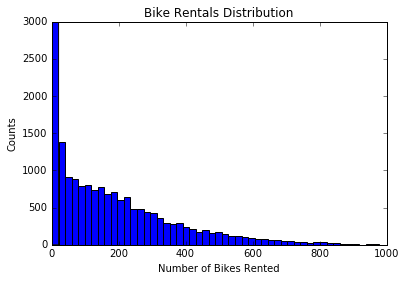

In [2]:
# Generate histogram toview distribution of total rentals
import matplotlib.pyplot as plt
%matplotlib inline

bike_rentals["cnt"].plot.hist(bins=50)
plt.title("Bike Rentals Distribution")
plt.ylabel("Counts")
plt.xlabel("Number of Bikes Rented")
plt.show()


By looking at the distribution of the count of bikes rented, we can see that it is right skewed with a lot of rows showing very few (0-20) bike rentals during specific hours. We will look at whether there is any correlation between each column an the 'cnt' (count) column.

In [3]:
bike_rentals.corr()["cnt"]

instant       0.278379
season        0.178056
yr            0.250495
mnth          0.120638
hr            0.394071
holiday      -0.030927
weekday       0.026900
workingday    0.030284
weathersit   -0.142426
temp          0.404772
atemp         0.400929
hum          -0.322911
windspeed     0.093234
casual        0.694564
registered    0.972151
cnt           1.000000
Name: cnt, dtype: float64

There is a pretty strong correlation between the count column as well as the number of registered riders and the number of casual riders. Other columns with moderate positive correlation are hour of day, temperature, and adjusted temperature. Humidity has a moderate negative correlation with count.

## Feature Generation
We will introduce some order into the hour column to bundle similar times together and enable our model to make better decisions that can treat related hours similarly.

In [4]:
# Write a function that categorizes numeric hour value into 6 hour time blocks
def assign_label(hr):
    if hr>=6 & hr<12:
        return 1
    if hr>=12 & hr<18:
        return 2
    if hr>=18 & hr<24:
        return 3
    else:
        return 4

# Apply assign_label method to hr column
bike_rentals["time_label"] = bike_rentals["hr"].apply(assign_label)
bike_rentals.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt,time_label
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16,1
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40,1
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32,1
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13,1
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1,1


# Select Error Metric
I will use the mean squared error metric to evaluate the performance of the machine learning algorithms. MSE works well on continuous numeric data, which fits our 'cnt' column in our dataset.

In [5]:
# Split 80% of data into training set
fraction = 0.8
train = bike_rentals.sample(frac = fraction)

In [6]:
# Select rows not in training set to be in testing set
test = bike_rentals.iloc[~bike_rentals.index.isin(train.index)]

In [7]:
test.shape

(3476, 18)

In [8]:
train.shape

(13903, 18)

## Apply linear regression
Since many of the columns are highly correlated with cnt, linear regression may work well. Linear regression is fairly resistant to overfitting because we generate a model 

In [15]:
predictors = list(bike_rentals.columns)
predictors.remove("cnt")
predictors.remove("casual")
predictors.remove("registered")
predictors.remove("dteday")
predictors

['instant',
 'season',
 'yr',
 'mnth',
 'hr',
 'holiday',
 'weekday',
 'workingday',
 'weathersit',
 'temp',
 'atemp',
 'hum',
 'windspeed',
 'time_label']

In [17]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

lr = LinearRegression()
lr.fit(train[predictors], train["cnt"])
prediction = lr.predict(test[predictors])
mse = mean_squared_error(test["cnt"], prediction)
mse

20161.091873190744

The MSE is fairly high, meaning that our linear model may not be the most accurate predictive model. Our data has very few high rental numbers but a lot of low rental numbers. However, the larger numbers are penalized more with MSE, which leads to a higher total error. We used all the columns in the dataset except casual, registered, and cnt because those give us information relating to count. The actual day doesn't give us much predictive value. However, it may not be best to use all the features as predictors.

## Apply decision tree algorithm
Decision trees tend to predict outcomes much more reliably than linear regression models, but are subject to overfitting. We will compare the error from linear regression to the error from the decision tree to pick the right algorithm.

In [18]:
from sklearn.tree import DecisionTreeRegressor

reg = DecisionTreeRegressor(min_samples_leaf = 5)
reg.fit(train[predictors], train["cnt"])
predictions_reg = reg.predict(test[predictors])
mse = mean_squared_error(test["cnt"], predictions_reg)
mse

2577.861387699027

In [19]:
# Experiment with various parameters of the DecisionTreeRegressor class
from sklearn.tree import DecisionTreeRegressor

reg = DecisionTreeRegressor(min_samples_leaf = 10)
reg.fit(train[predictors], train["cnt"])
predictions_reg = reg.predict(test[predictors])
mse = mean_squared_error(test["cnt"], predictions_reg)
mse

2567.95954504211

In [35]:
# Experiment with various parameters of the DecisionTreeRegressor class
from sklearn.tree import DecisionTreeRegressor

reg = DecisionTreeRegressor(max_depth = 12)
reg.fit(train[predictors], train["cnt"])
predictions_reg = reg.predict(test[predictors])
mse = mean_squared_error(test["cnt"], predictions_reg)
mse

2931.7823088027826

The error increases with a minimum number of samples per leaf greater than 5. The error increases with a max depth of the tree beyond 12. Altogether, the decision tree has a much smaller error than the linear model. The decision tree regressor appears to have much higher accuracy than the linear model as it takes into account nonlinear predictors.

## Apply random forest algorithm
We will also compare how much more accurate a random forest is than the decision tree algorithm. Since random forests are constructed over random sampling of features, they are less prone to overfitting.

In [36]:
from sklearn.ensemble import RandomForestRegressor

reg = RandomForestRegressor(min_samples_leaf= 5)
reg.fit(train[predictors], train["cnt"])
predictions_rf = reg.predict(test[predictors])
mse = mean_squared_error(test["cnt"], predictions_rf)
mse

1900.4789008605005

By removing some of the sources from overfitting, our random forest model is more accurate than our decision tree model.

## Next Steps
Now that we've compared different algorithms to choose the best model to use to predict bike rental counts, we can engineer more features to use as predictors that better increase accuracy of our model. Features to consider are combining temperature, humidity, a